# **_Autonomous and Adaptive Systems_ - 2025**
## **Mini-Project**:*Overcooked* - A2C implementation

### Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow import keras
from tqdm import tqdm
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.planning.planners import MediumLevelActionManager

2025-06-18 10:14:01.471088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Testing _Overcooked_ environment

- `base_mdp` = An MDP grid world based off of the Overcooked game.
- `base_env` = An environment wrapper for the OvercookedGridworld Markov Decision Process. The environment keeps track of the current state of the agent, updates it as the agent takes actions, and provides rewards to the agent.
- `env`= Similar to gym env.

In [2]:
base_mdp = OvercookedGridworld.from_layout_name("cramped_room", old_dynamics = True) # or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=400)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

There are different experimetnal layouts:
- ***Cramped Room*** presents low-level coordination challenges: in this shared, confined space it is very easy for the agents to collide.
- ***Asymmetric Advantages*** tests whether players can choose high-level strategies that play to their strengths.
- ***Coordination Ring***, players must coordinate to travel between the bottom left and top right corners of the layout.
- ***Forced Coordination*** removes collision coordination problems, and forces players to develop a high-level joint strategy, since neither player can serve a dish by themselves.
- ***Counter Circuit*** involves a non-obvious coordination strategy, where onions are passed over the counter to the pot, rather than being carried around.

#### **Actions**

The possible actions are: _up, down, left, right, noop,_ and _"interact"_

In [3]:
print('The action space has dimension: {}'.format(env.action_space))

The action space has dimension: Discrete(6)


#### **Observations**

In [4]:
observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step((action, action))
observation

{'both_agent_obs': (array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0., -1.,
          2.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
          1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          1., -1.,  1.,  2.,  1.]),
  array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0., -2.,  0.,  0.,  0., -1.,  2.,  0.,  0.,  0.,  0.,  1.,
          2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,

### Understanding the _Overcooked_ **observations** to apply shaping

- `[0:4]` pi_orientation: length 4 one-hot-encoding of direction currently facing
- `[4:8]` pi_obj: length 4 one-hot-encoding of object currently being held (all 0s if no object held) (onion|soup|dish|tomato)
- `[8:20]` pi_closest_{onion|tomato|dish|soup|serving|empty_counter}: (dx, dy) where dx = x dist to item, dy = y dist to item. (0, 0) if item is currently held
- `[20:22]` pi_cloest_soup_n_{onions|tomatoes}: int value for number of this ingredient in closest soup ???
- `[22:23]` pi_closest_pot_{j}_exists: {0, 1} depending on whether jth closest pot found. If 0, then all other pot features are 0. Note: can be 0 even if there are more than j pots on layout, if the pot is not reachable by player i
- `[23:27]` pi_closest_pot_{j}_{is_empty|is_full|is_cooking|is_ready}: {0, 1} depending on boolean value for jth closest pot
- `[27:29]` pi_closest_pot_{j}_{num_onions|num_tomatoes}: int value for number of this ingredient in jth closest pot
- `[29:30]` pi_closest_pot_{j}_cook_time: int value for seconds remaining on soup. -1 if no soup is cooking
- `[30:32]` pi_closest_pot_{j}: (dx, dy) to jth closest pot from player i location
- `[32:36]` pi_wall: length 4 boolean value of whether player i has wall in each direction

In [5]:
class OvercookedRewardShaping(Overcooked):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def step(self, actions):
        observation, base_reward, done, info = super().step(actions)
        if base_reward != 0:
            print("Soup delivered! Voto: {}".format(base_reward)) # base_reward is 20 if soup is delivered
        shaped_reward = base_reward + self._compute_shaping(observation['both_agent_obs'])
        return observation, shaped_reward, done, info

    def _compute_shaping(self, observations):
        shaping = 0
        for obs in observations:
            holding_vector = obs[4:8]
            holding_soup = obs[5:6]
            soup_full_cooking_ready = obs[24:27]
            soup_empty = obs[23:24]
            soup_cooking = obs[25:26]
            pot_onions = obs[27:28]
            
            # Penalty if holding an object
            #if holding_vector.any():
            #    shaping -= 0.05
            # Reward if holding a soup
            #if holding_soup.any():
            #    shaping += 0.1
            # Reward if soup is full/cooking/ready
            if soup_cooking.any():
                shaping += 0.3
            # Reward if onion are putted into the soup
            #if soup_empty.any():
            # shaping += int(pot_onions)*0.01

        return shaping

In [6]:
env = OvercookedRewardShaping(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

#### Testing a random episode

In [7]:
for i_episode in range(1):
    observation = env.reset()
    
    for t in range(100):
        action = env.action_space.sample()
        state = env.step((action, action))

env.close()

### **Networks**

In [8]:
num_inputs = 96 # length of the observation array
num_actions = 6
num_hidden = 128

#### _Actor_ model
- **Actor**: This takes as input the _state of our environment_ and returns a _probability value_ for each action in its action space.

In [14]:
# Actor-Critic for Player 1
actor = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_actions, activation='softmax')
])

actor = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_actions, activation='softmax')
])

actor_optimizer = keras.optimizers.Adam(learning_rate=1e-7)

#### _Critic_ model
- **Critic**: This takes as input the _state of our environment_ and returns an estimate of _total rewards_ in the future.

In [15]:
critic = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(1)
])

critic = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_hidden//4, activation='relu'),
    keras.layers.Dense(1)
])

critic_optimizer = keras.optimizers.Adam(learning_rate=1e-7)

### **Training**

Sources: 
- https://medium.com/data-science-in-your-pocket/advantage-actor-critic-a2c-algorithm-in-reinforcement-learning-with-codes-and-examples-using-e810273c0c9e
- https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic


In [12]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
max_steps_per_episode = 1000

mse_loss = keras.losses.MeanSquaredError()

num_episodes = 1
n_step_before_update = 5

#### <u>Update</u>: After each **episode**

In [ ]:
chef1_action_probs_history = []
chef1_critic_value_history = []
chef2_action_probs_history = []
chef2_critic_value_history = []
rewards_history = []

running_reward = 0

#while True:  # Run until solved
for episode in tqdm(range(num_episodes)):
    observation = env.reset() #observation of the starting state
    episode_reward = 0
    
    with tf.GradientTape(persistent = True) as tape:
        while True:

            chef1_observation = observation['both_agent_obs'][0]
            chef2_observation = observation['both_agent_obs'][1]

            #chef1_observation = keras.ops.convert_to_tensor([chef1_observation])
            chef1_observation = keras.ops.convert_to_tensor(chef1_observation)
            chef1_observation = keras.ops.expand_dims(chef1_observation, 0)

            chef2_observation = keras.ops.convert_to_tensor(chef2_observation)
            chef2_observation = keras.ops.expand_dims(chef2_observation, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            chef1_action_probs = actor(chef1_observation)
            chef1_critic_value = critic(chef1_observation)
            chef1_critic_value_history.append(chef1_critic_value[0, 0])

            chef2_action_probs = actor(chef2_observation)
            chef2_critic_value = critic(chef2_observation)
            chef2_critic_value_history.append(chef2_critic_value[0, 0])

            # Sample action from action probability distribution
            chef1_action = np.random.choice(num_actions, p=np.squeeze(chef1_action_probs))
            chef1_action_probs_history.append(keras.ops.log(chef1_action_probs[0, chef1_action]))

            chef2_action = np.random.choice(num_actions, p=np.squeeze(chef2_action_probs))
            chef2_action_probs_history.append(keras.ops.log(chef2_action_probs[0, chef2_action]))

            # Apply the sampled action in our environment
            next_observation, reward, done, info = env.step((chef1_action, chef2_action))
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0

        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update the networks - PLAYER 1 #
        chef1_history = zip(chef1_action_probs_history, chef1_critic_value_history, returns)
        chef1_actor_losses = []
        chef1_critic_losses = []

        for log_prob, value, ret in chef1_history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up receiving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            chef1_actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            chef1_critic_losses.append(
                mse_loss(keras.ops.expand_dims(value, 0), keras.ops.expand_dims(ret, 0))
            )

        # Calculating loss values to update the networks - PLAYER 2 #
        chef2_history = zip(chef2_action_probs_history, chef2_critic_value_history, returns)
        chef2_actor_losses = []
        chef2_critic_losses = []

        for log_prob, value, ret in chef2_history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up receiving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            chef2_actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            chef2_critic_losses.append(
                mse_loss(keras.ops.expand_dims(value, 0), keras.ops.expand_dims(ret, 0))
            )

        # Summing up all the losses
        actor_loss_value = sum(chef1_actor_losses) + sum(chef2_actor_losses)
        critic_loss_value = sum(chef1_critic_losses) + sum(chef2_critic_losses)
        
    # Backpropagation for both Actor & Critic   
    actor_grads = tape.gradient(actor_loss_value, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss_value, critic.trainable_variables)
    
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    # Clear the loss and reward history
    chef1_action_probs_history.clear()
    chef1_critic_value_history.clear()
    chef2_action_probs_history.clear()
    chef2_critic_value_history.clear()
    rewards_history.clear()
        
    del tape # remove the reference to the tape and invoke garbage collection

    # Log details
    if (episode + 1) % 5 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode+1))

50 episodes at the time (learning rate = 5e-7)
    - UP --> 1.6-7, soup: 2
             2-10.7, soup: 6 
    - DOWN --> 0.5-4.5, soup: 3
               2-4, soup: 2
100 episodes at the time (learning rate = 5e-7)
    - UP --> 0.5-6.6, soup: 0
             1.5-7.6, soup: 4
             1-7.5, soup: 1
300 episodes at the time (learning rate = 5e-8)
    - DOWN --> 0.5-6.5, soup: 18 
300 episodes at the time (learning rate = 5e-9)
    - DOWN --> 0.5-6.5, soup: 18 

700 episodes - 128 net_dimensions - 1e-4 --> No learning at all
700 episodes - 128 net_dimensions - 1e-5 --> No learning at all

100 episodes - 64 net_dimensions - 1e-6 --> No learning at all
100 episodes - 64 net_dimensions - 1e-7 --> No learning at all

100 episodes - 256 net_dimensions - 1e-5 --> No learning at all, it goes to 0
180 episodes - 256 net_dimensions - 1e-8 --> 


#### <u>Update</u>: After each **step**

  1%|          | 1/100 [00:52<1:26:15, 52.28s/it]

Soup delivered! Voto: 20


  4%|▍         | 4/100 [03:44<1:29:13, 55.76s/it]

running reward: 1.42 at episode 4 Actor Loss: -0.25 - Critic Loss: 0.04
Soup delivered! Voto: 20


  9%|▉         | 9/100 [07:53<1:15:26, 49.74s/it]

running reward: 2.94 at episode 9 Actor Loss: 0.31 - Critic Loss: 0.03


 14%|█▍        | 14/100 [11:47<1:07:07, 46.83s/it]

running reward: 3.33 at episode 14 Actor Loss: 0.18 - Critic Loss: 0.03


 19%|█▉        | 19/100 [15:39<1:03:14, 46.85s/it]

running reward: 4.15 at episode 19 Actor Loss: -0.36 - Critic Loss: 0.12


 24%|██▍       | 24/100 [19:24<57:21, 45.29s/it]  

running reward: 3.73 at episode 24 Actor Loss: 0.32 - Critic Loss: 0.03


 29%|██▉       | 29/100 [23:09<53:16, 45.02s/it]

running reward: 3.97 at episode 29 Actor Loss: 0.09 - Critic Loss: 0.04


 34%|███▍      | 34/100 [26:56<49:46, 45.25s/it]

running reward: 4.07 at episode 34 Actor Loss: -0.29 - Critic Loss: 0.14


 39%|███▉      | 39/100 [30:43<46:00, 45.25s/it]

running reward: 3.69 at episode 39 Actor Loss: -0.37 - Critic Loss: 0.05


 44%|████▍     | 44/100 [34:27<41:53, 44.89s/it]

running reward: 3.40 at episode 44 Actor Loss: -0.13 - Critic Loss: 0.01


 47%|████▋     | 47/100 [36:44<39:56, 45.21s/it]

Soup delivered! Voto: 20


 49%|████▉     | 49/100 [38:14<38:16, 45.03s/it]

running reward: 5.75 at episode 49 Actor Loss: -0.51 - Critic Loss: 0.09


 54%|█████▍    | 54/100 [42:00<34:34, 45.10s/it]

running reward: 4.96 at episode 54 Actor Loss: -0.10 - Critic Loss: 0.03


 59%|█████▉    | 59/100 [45:42<30:46, 45.04s/it]

running reward: 4.20 at episode 59 Actor Loss: -0.16 - Critic Loss: 0.14


 64%|██████▍   | 64/100 [49:21<26:24, 44.02s/it]

running reward: 4.26 at episode 64 Actor Loss: -0.22 - Critic Loss: 0.06


 69%|██████▉   | 69/100 [52:57<22:27, 43.46s/it]

running reward: 3.29 at episode 69 Actor Loss: 0.06 - Critic Loss: 0.03


 74%|███████▍  | 74/100 [56:31<18:27, 42.60s/it]

running reward: 3.53 at episode 74 Actor Loss: 0.10 - Critic Loss: 0.00


 79%|███████▉  | 79/100 [1:00:04<14:53, 42.52s/it]

running reward: 3.79 at episode 79 Actor Loss: -0.37 - Critic Loss: 0.05


 81%|████████  | 81/100 [1:01:27<13:21, 42.21s/it]

Soup delivered! Voto: 20


 84%|████████▍ | 84/100 [1:03:36<11:21, 42.58s/it]

running reward: 4.78 at episode 84 Actor Loss: 0.14 - Critic Loss: 0.01


 89%|████████▉ | 89/100 [1:07:06<07:43, 42.10s/it]

running reward: 3.70 at episode 89 Actor Loss: -0.16 - Critic Loss: 0.03


 94%|█████████▍| 94/100 [1:10:33<04:09, 41.65s/it]

running reward: 2.86 at episode 94 Actor Loss: 0.10 - Critic Loss: 0.00


 99%|█████████▉| 99/100 [1:14:01<00:41, 41.45s/it]

running reward: 2.21 at episode 99 Actor Loss: 0.06 - Critic Loss: 0.01


100%|██████████| 100/100 [1:14:50<00:00, 44.90s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

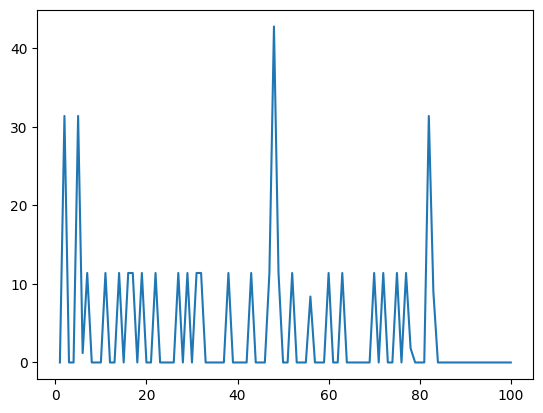

In [ ]:
running_reward = 0
reward_histroy = []

actor_optimizer = keras.optimizers.Adam(learning_rate=7e-3)
critic_optimizer = keras.optimizers.Adam(learning_rate=7e-3)

losses = {'Actor Loss': [], 'Critic Loss': []}

#while True:  # Run until solved
for episode in tqdm(range(1, num_episodes+1)):
    observation = env.reset() #observation of the starting state
    episode_reward = 0
    done = False
    
    while not done:
        with tf.GradientTape(persistent = True) as tape:

            chef1_observation = observation['both_agent_obs'][0]
            chef2_observation = observation['both_agent_obs'][1]

            #chef1_observation = keras.ops.convert_to_tensor([chef1_observation])
            chef1_observation = tf.convert_to_tensor(chef1_observation, dtype = tf.float32)
            chef1_observation = keras.ops.expand_dims(chef1_observation, 0)

            chef2_observation = tf.convert_to_tensor(chef2_observation, dtype = tf.float32)
            chef2_observation = keras.ops.expand_dims(chef2_observation, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state (actor & critic networks)
            chef1_action_probs = actor(chef1_observation)
            chef1_observation_value = critic(chef1_observation)

            chef2_action_probs = actor(chef2_observation)
            chef2_observation_value = critic(chef2_observation)

            # Sample action from action probability distribution
            chef1_action_probs_dist = tfp.distributions.Categorical(probs=chef1_action_probs)
            chef1_action = chef1_action_probs_dist.sample()
            
            chef2_action_probs_dist = tfp.distributions.Categorical(probs=chef2_action_probs)
            chef2_action = chef2_action_probs_dist.sample()
            '''
            chef1_action = np.random.choice(num_actions, p=np.squeeze(chef1_action_probs))
            chef2_action = np.random.choice(num_actions, p=np.squeeze(chef2_action_probs))
            '''

            # Apply the sampled action in our environment
            next_observation, reward, done, info = env.step((int(chef1_action), int(chef2_action)))
            episode_reward += reward
            observation = next_observation

            # Lets convert to tensor all we need
            chef1_next_observation = next_observation['both_agent_obs'][0]
            chef2_next_observation = next_observation['both_agent_obs'][1]

            chef1_next_observation = tf.convert_to_tensor([chef1_next_observation], dtype = tf.float32)
            chef2_next_observation = tf.convert_to_tensor([chef2_next_observation], dtype = tf.float32)
            reward = tf.convert_to_tensor([reward], dtype='float32')

            # Predict future rewards from environment state
            chef1_next_observation_value = critic(chef1_next_observation)
            chef2_next_observation_value = critic(chef2_next_observation)

            # To compute the loss we need to get rid of the extra dimenion
            #chef1_observation_value = tf.squeeze(chef1_observation_value)
            #chef2_observation_value = tf.squeeze(chef2_observation_value)

            chef1_next_observation_value = tf.squeeze(chef1_next_observation_value)
            chef2_next_observation_value = tf.squeeze(chef2_next_observation_value)

            # The advantage function
            chef1_target = reward + gamma*chef1_next_observation_value*(1-int(done))
            chef2_target = reward + gamma*chef2_next_observation_value*(1-int(done))
            
            chef1_advantage = chef1_target - chef1_observation_value
            chef2_advantage = chef2_target - chef2_observation_value
            
            '''
            chef1_delta = reward + gamma*chef1_next_observation_value*(1-int(done)) - chef1_observation_value
            chef2_delta = reward + gamma*chef2_next_observation_value*(1-int(done)) - chef2_observation_value
            '''

            # Critic loss with MSE loss
            chef1_critic_loss = mse_loss(chef1_observation_value, chef1_target)
            chef2_critic_loss = mse_loss(chef2_observation_value, chef2_target)
            critic_loss = (0.5)*chef1_critic_loss + (0.5)*chef2_critic_loss 

            '''
            chef2_critic_loss = 0.5*(chef2_delta**2)
            critic_loss = (0.5)*chef1_critic_loss + (0.5)*chef2_critic_loss 
            '''

            # Actor loss
            # To compute the log probabilities
            chef1_log_probs = chef1_action_probs_dist.log_prob(chef1_action)
            chef2_log_probs = chef2_action_probs_dist.log_prob(chef2_action)

            chef1_actor_loss = -chef1_log_probs*chef1_advantage
            chef2_actor_loss = -chef2_log_probs*chef2_advantage
            actor_loss = (0.5)*chef1_actor_loss + (0.5)*chef2_actor_loss

        # Backpropagation for both Actor & Critic   
        actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
        critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
        
        actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
        critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

        del tape

    # Let collect the reward of this episode
    reward_histroy.append(episode_reward)
    # Update running reward to check condition for solving
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

    # Lets save the losses
    losses['Actor Loss'].append(actor_loss)
    losses['Critic Loss'].append(critic_loss)
    
    # Log details
    if (episode + 1) % 5 == 0:
        template = "running reward: {:.2f} at episode {}"
        template2 = "Actor Loss: {:.2f} - Critic Loss: {:.2f}"
        print(template.format(running_reward, episode), template2.format(tf.squeeze(losses['Actor Loss'][-1]), tf.squeeze(losses['Critic Loss'][-1])))

# Plot the reward over the episodes
x = [i+1 for i in range(num_episodes)]
y = reward_histroy
plt.plot(x,y)
plt.show
 


### Test for Visualization

In [39]:
import pygame

# 1) Initialize Pygame & Visualizer
pygame.init()
visualizer = StateVisualizer()

# 2) Grab your grid and do one dummy render to get a surface
grid = base_env.mdp.terrain_mtx
_ = env.reset()
surf = visualizer.render_state(base_env.state, grid=grid)

# 3) Use that surface’s size for your window
win_w, win_h = surf.get_size()
screen = pygame.display.set_mode((win_w, win_h), pygame.RESIZABLE)
clock  = pygame.time.Clock()

# 4) Main loop: render each frame & blit into the same window
running = True
observation = env.reset() #observation of the starting state
soup_delivered = 0

while running:
    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False
    
    # observation of the environment
    chef1_observation = observation['both_agent_obs'][0]
    chef2_observation = observation['both_agent_obs'][1]

    chef1_observation = keras.ops.convert_to_tensor(chef1_observation)
    chef1_observation = keras.ops.expand_dims(chef1_observation, 0)

    chef2_observation = keras.ops.convert_to_tensor(chef2_observation)
    chef2_observation = keras.ops.expand_dims(chef2_observation, 0)
    
    # step the environment
    chef1_action_probs = actor(chef1_observation)
    chef1_action = np.random.choice(num_actions, p=np.squeeze(chef1_action_probs))
    
    chef2_action_probs = actor(chef2_observation)
    chef2_action = np.random.choice(num_actions, p=np.squeeze(chef2_action_probs))

    # try to step; if episode is over, catch and reset
    try:
        # Overcooked wrapper returns (obs_p0, obs_p1, reward, done, info)
        observation, reward, done, info = env.step((chef1_action, chef2_action))
        if reward > 19:
            soup_delivered += 1
    except AssertionError:
        # base_env.is_done() was True → reset and continue
        env.reset()
        break

    # render the new state
    surf = visualizer.render_state(base_env.state, grid=grid)

    # draw it
    screen.blit(surf, (0, 0))
    pygame.display.flip()

    clock.tick(15)   # cap at 30 FPS

pygame.quit()

print(f"Soup delivered: {soup_delivered}")


Soup delivered: 0
